## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

# 試改變 monitor "Validation Accuracy" 並比較結果

In [1]:
import os
from tensorflow.python import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from tensorflow.python.keras.layers import BatchNormalization


def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)

    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(
                units=n_units,
                activation="relu",
                name="hidden_layer" + str(i + 1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(
                units=n_units,
                activation="relu",
                name="hidden_layer" + str(i + 1))(x)
            x = BatchNormalization()(x)

    out = keras.layers.Dense(
        units=output_units, activation="softmax", name="output")(x)

    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
from tensorflow.python.keras.callbacks import EarlyStopping

results = {}

for i in range(2):
    keras.backend.clear_session()
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(
        lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(
        loss="categorical_crossentropy", metrics=["acc"], optimizer=optimizer)

    # 載入 Callbacks
    if i == 0:
        earlystop = EarlyStopping(monitor="val_loss", patience=5, verbose=1)
    else:
        earlystop = EarlyStopping(monitor="val_acc", patience=5, verbose=1)

    model.fit(
        x_train,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(x_test, y_test),
        shuffle=True,
        callbacks=[earlystop])

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "val_loss" if i == 0 else "val_acc"
    results[exp_name_tag] = {
        'train-loss': train_loss,
        'valid-loss': valid_loss,
        'train-acc': train_acc,
        'valid-acc': valid_acc
    }

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_v1 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 128)               512   

50000/50000 [==============================] - 1s 24us/sample - loss: 1.2041 - acc: 0.5843 - val_loss: 1.4803 - val_acc: 0.4833
Epoch 15/50
50000/50000 [==============================] - 1s 23us/sample - loss: 1.1810 - acc: 0.5924 - val_loss: 1.4699 - val_acc: 0.4872
Epoch 16/50
50000/50000 [==============================] - 1s 24us/sample - loss: 1.1580 - acc: 0.6013 - val_loss: 1.4700 - val_acc: 0.4845
Epoch 17/50
50000/50000 [==============================] - 1s 24us/sample - loss: 1.1342 - acc: 0.6104 - val_loss: 1.4812 - val_acc: 0.4832
Epoch 18/50
50000/50000 [==============================] - 1s 24us/sample - loss: 1.1135 - acc: 0.6192 - val_loss: 1.4715 - val_acc: 0.4833
Epoch 19/50
50000/50000 [==============================] - 1s 24us/sample - loss: 1.0898 - acc: 0.6263 - val_loss: 1.4554 - val_acc: 0.4936
Epoch 20/50
50000/50000 [==============================] - 1s 24us/sample - loss: 1.0672 - acc: 0.6368 - val_loss: 1.4691 - val_acc: 0.4866
Epoch 21/50
50000/50000 [=======

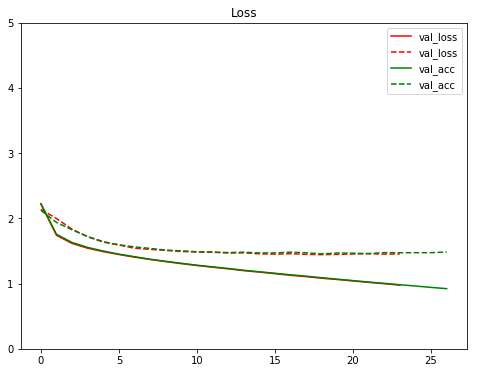

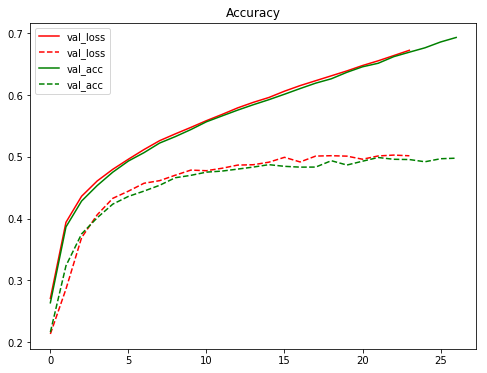

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(
        range(len(results[cond]['train-loss'])),
        results[cond]['train-loss'],
        '-',
        label=cond,
        color=color_bar[i])
    plt.plot(
        range(len(results[cond]['valid-loss'])),
        results[cond]['valid-loss'],
        '--',
        label=cond,
        color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(
        range(len(results[cond]['train-acc'])),
        results[cond]['train-acc'],
        '-',
        label=cond,
        color=color_bar[i])
    plt.plot(
        range(len(results[cond]['valid-acc'])),
        results[cond]['valid-acc'],
        '--',
        label=cond,
        color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

# 調整 earlystop 的等待次數至 10, 25 並比較結果

In [9]:
results = {}

earlystop = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

for i in range(2):
    keras.backend.clear_session()
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(
        lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(
        loss="categorical_crossentropy", metrics=["acc"], optimizer=optimizer)

    # 載入 Callbacks
    if i == 0:
        earlystop = EarlyStopping(monitor="val_acc", patience=10, verbose=1)
    else:
        earlystop = EarlyStopping(monitor="val_acc", patience=25, verbose=1)

    model.fit(
        x_train,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(x_test, y_test),
        shuffle=True,
        callbacks=[earlystop])

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "patience: 10" if i == 0 else "patience: 25"
    results[exp_name_tag] = {
        'train-loss': train_loss,
        'valid-loss': valid_loss,
        'train-acc': train_acc,
        'valid-acc': valid_acc
    }

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_v1 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 128)               512   

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 35us/sample - loss: 2.2465 - acc: 0.2605 - val_loss: 2.1109 - val_acc: 0.2304
Epoch 2/50
50000/50000 [==============================] - 1s 23us/sample - loss: 1.7477 - acc: 0.3915 - val_loss: 1.9556 - val_acc: 0.2964
Epoch 3/50
50000/50000 [==============================] - 1s 23us/sample - loss: 1.6152 - acc: 0.4368 - val_loss: 1.8212 - val_acc: 0.3676
Epoch 4/50
50000/50000 [==============================] - 1s 23us/sample - loss: 1.5393 - acc: 0.4649 - val_loss: 1.7382 - val_acc: 0.3913
Epoch 5/50
50000/50000 [==============================] - 1s 23us/sample - loss: 1.4830 - acc: 0.4845 - val_loss: 1.6431 - val_acc: 0.4255
Epoch 6/50
50000/50000 [==============================] - 1s 24us/sample - loss: 1.4379 - acc: 0.5009 - val_loss: 1.5926 - val_acc: 0.4405
Epoch 7/50
50000/50000 [==============================] - 1s 24us/sample - loss: 1.3980 - acc: 0.5153 - val_loss: 1.

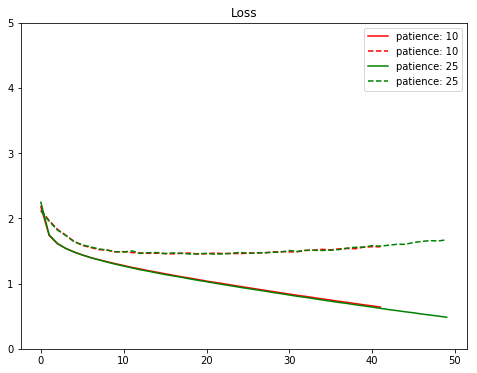

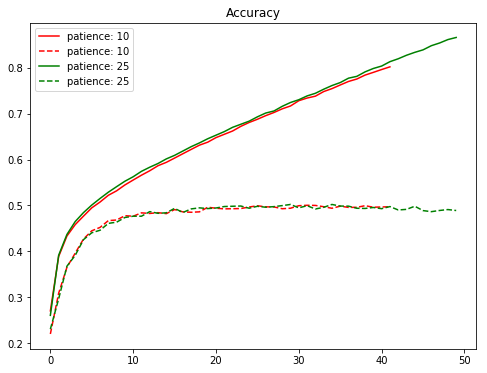

In [10]:
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(
        range(len(results[cond]['train-loss'])),
        results[cond]['train-loss'],
        '-',
        label=cond,
        color=color_bar[i])
    plt.plot(
        range(len(results[cond]['valid-loss'])),
        results[cond]['valid-loss'],
        '--',
        label=cond,
        color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(
        range(len(results[cond]['train-acc'])),
        results[cond]['train-acc'],
        '-',
        label=cond,
        color=color_bar[i])
    plt.plot(
        range(len(results[cond]['valid-acc'])),
        results[cond]['valid-acc'],
        '--',
        label=cond,
        color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()